#### Student Name: Adi Dereviani, Ron Dagani
#### Student ID: 305674731, 318170917

# Overview
### Due Dec 14th

##Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate but EACH must turn in a copy of the homework.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. Please leave the audio loaded when submitting the homework.

YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits! Upload your completed assignment on moodle.

In [1]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
    "305674731" : "318170917"
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from numpy.linalg import svd
from scipy.stats.mstats import gmean
from matplotlib import rcParams
import scipy
import os
import sys
import glob
import pickle
from music21 import converter, instrument, note, chord, stream
import torch
np.random.seed(4)

# PCA with a Linear Autoencoder


In this problem, we will practice using basic neural network procedures by running an autoencoder network.
This network is implemented in TensorFlow (essentially Keras with an expanded toolset); the functions we call are nearly identical to those you will see in Keras.

Let's create a sin+noise signal to use as input to our network:

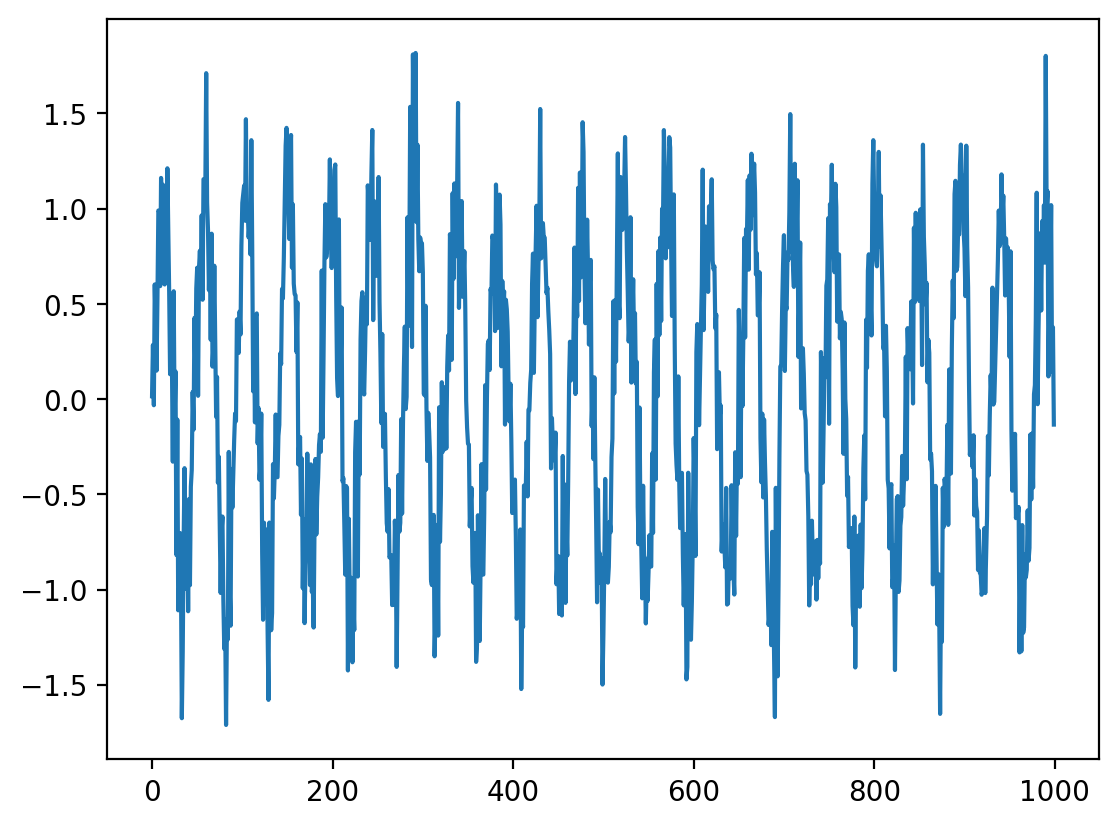

In [3]:
f0 = 215
fs = 10000
T = 3
Ns = fs*T

def buffer(input_data, sample_rate, window_size, hop_size):
    output = np.array([input_data[i:i+window_size] for i in range(0, len(input_data)-window_size, hop_size)])
    return output.T

s = np.sin(2*np.pi*f0*np.arange(Ns)/fs)

n = np.random.randn(Ns)

x = s + 0.3*n

plt.plot(x[:1000])
wavfile.write('out2.wav', fs, x)
xmat = buffer(x,fs,400,200)

Here we create an AE with 2 hidden layers.

This neural network is implemented in TensorFlow.

Please review the code cells below, and answer the questions that follow.

In [4]:
# Initialize parameters
n_inputs = xmat.shape[0]
n_hidden = 2
learning_rate = 0.01
n_iterations = 10000

# Convert data to PyTorch tensors
X_train = torch.tensor(xmat.T, dtype=torch.float32)
X_test = X_train.clone()

# Initialize weights
W = torch.empty(n_inputs, n_hidden, dtype=torch.float32, requires_grad=True)
torch.nn.init.trunc_normal_(W, std=0.1)

# Training loop
optimizer = torch.optim.Adam([W], lr=learning_rate)


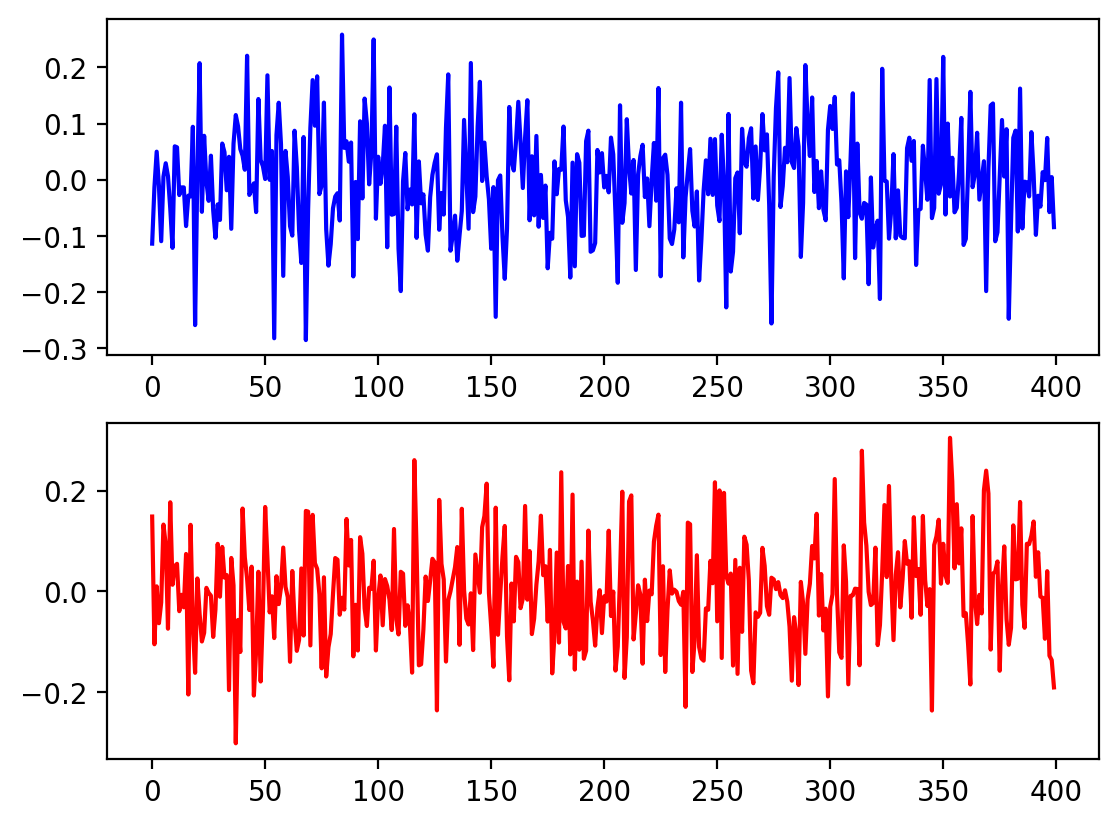

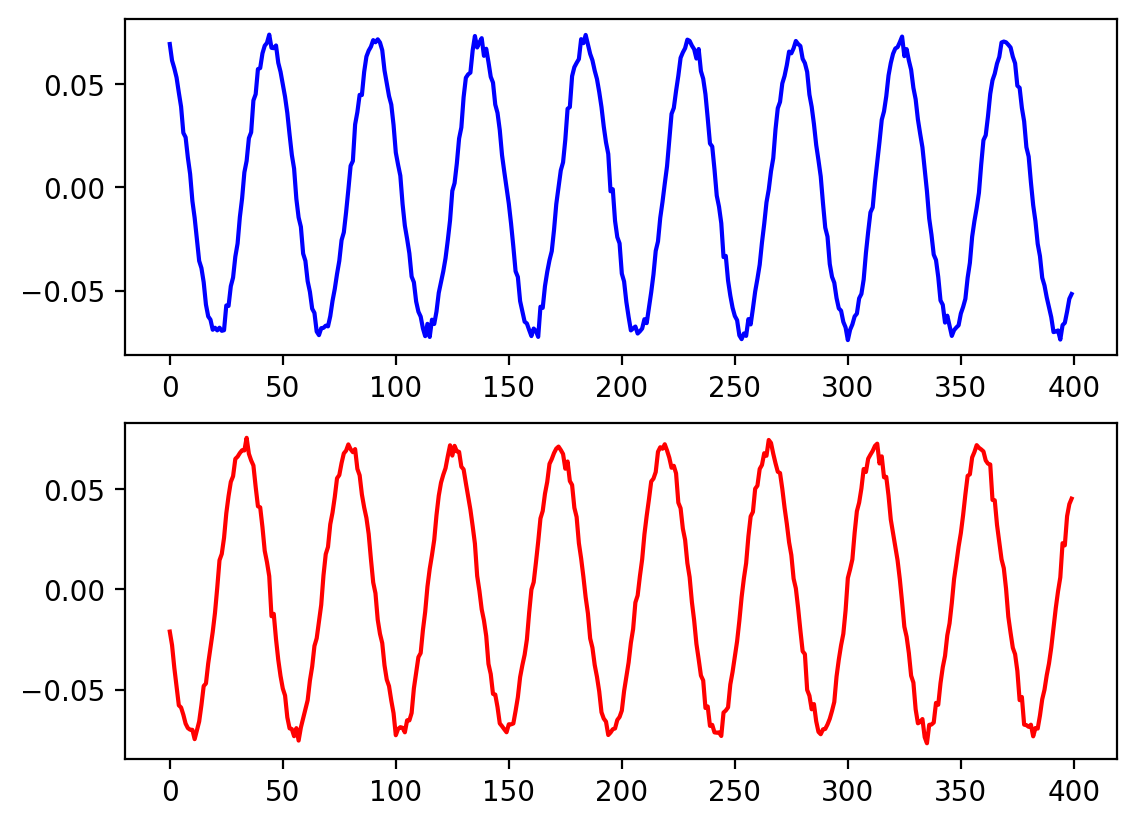

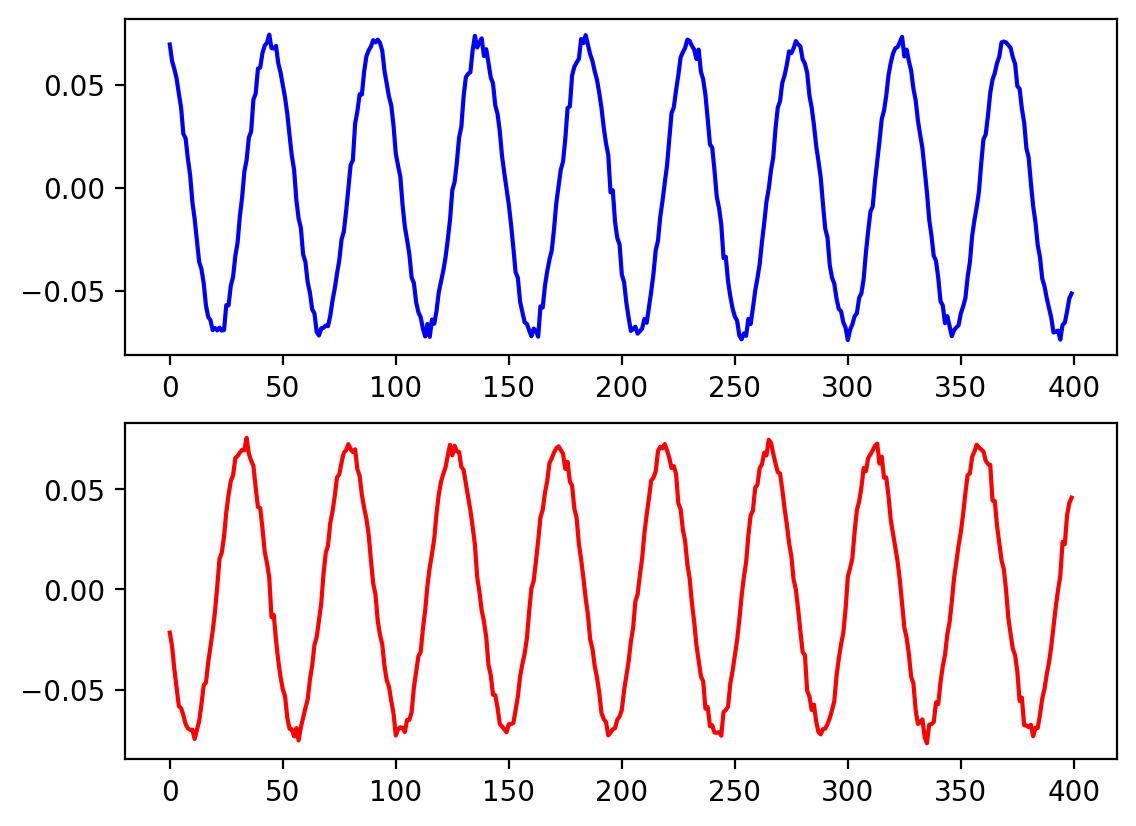

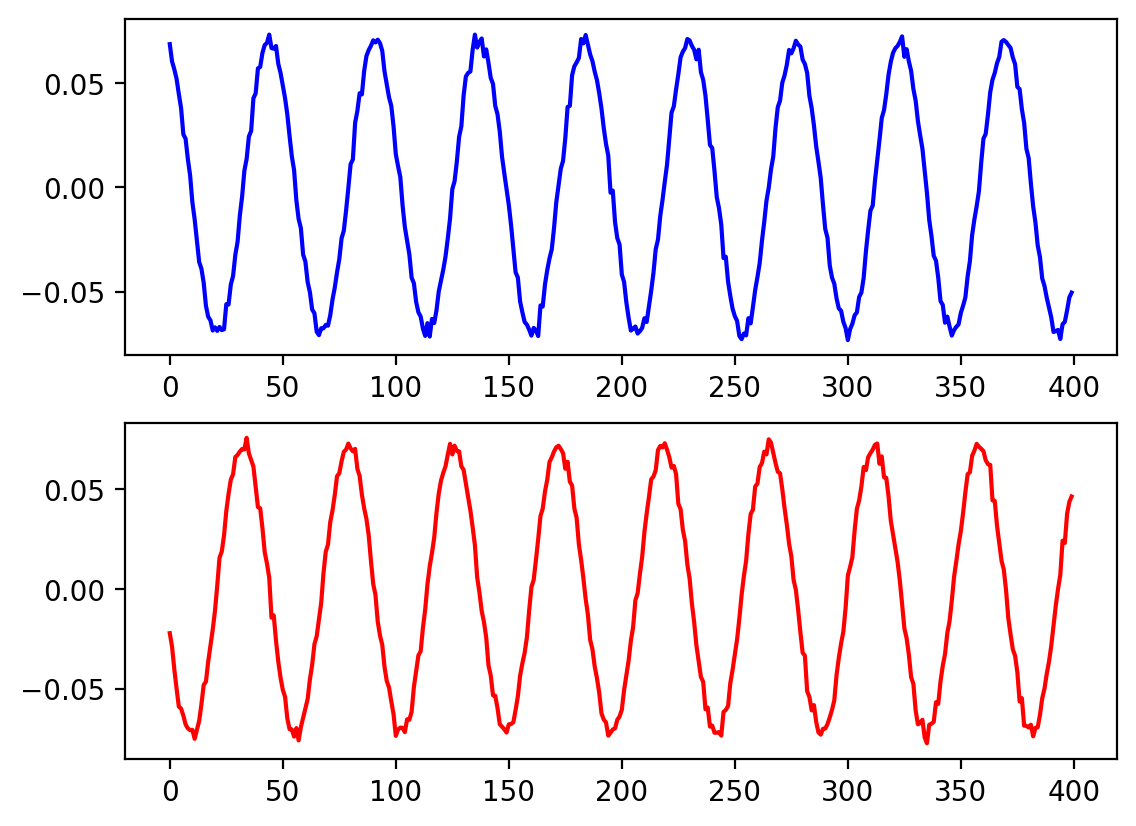

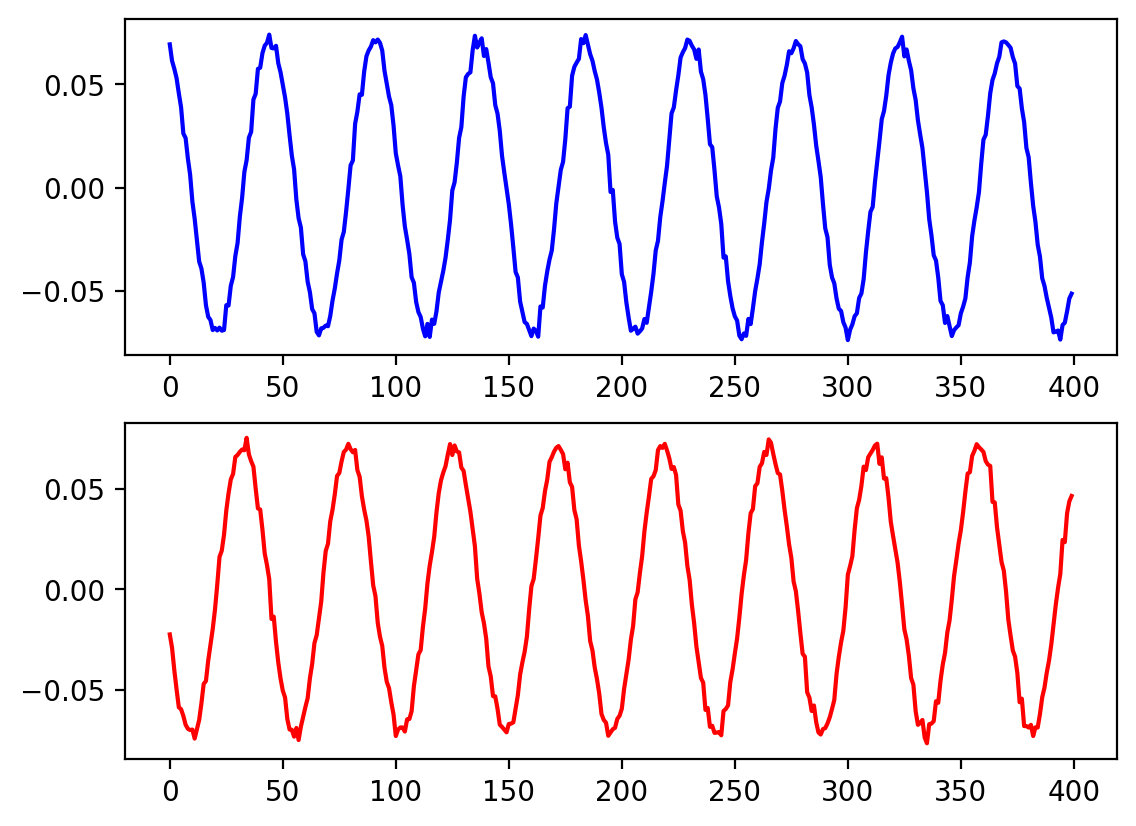

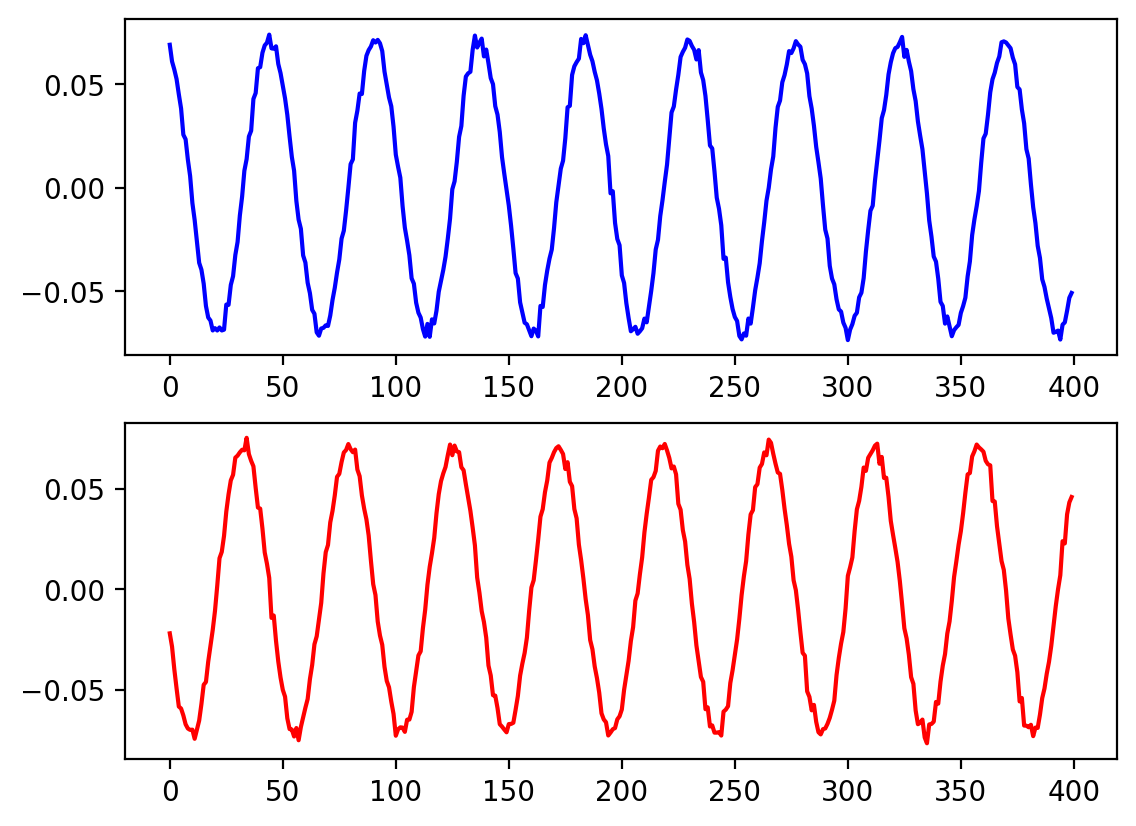

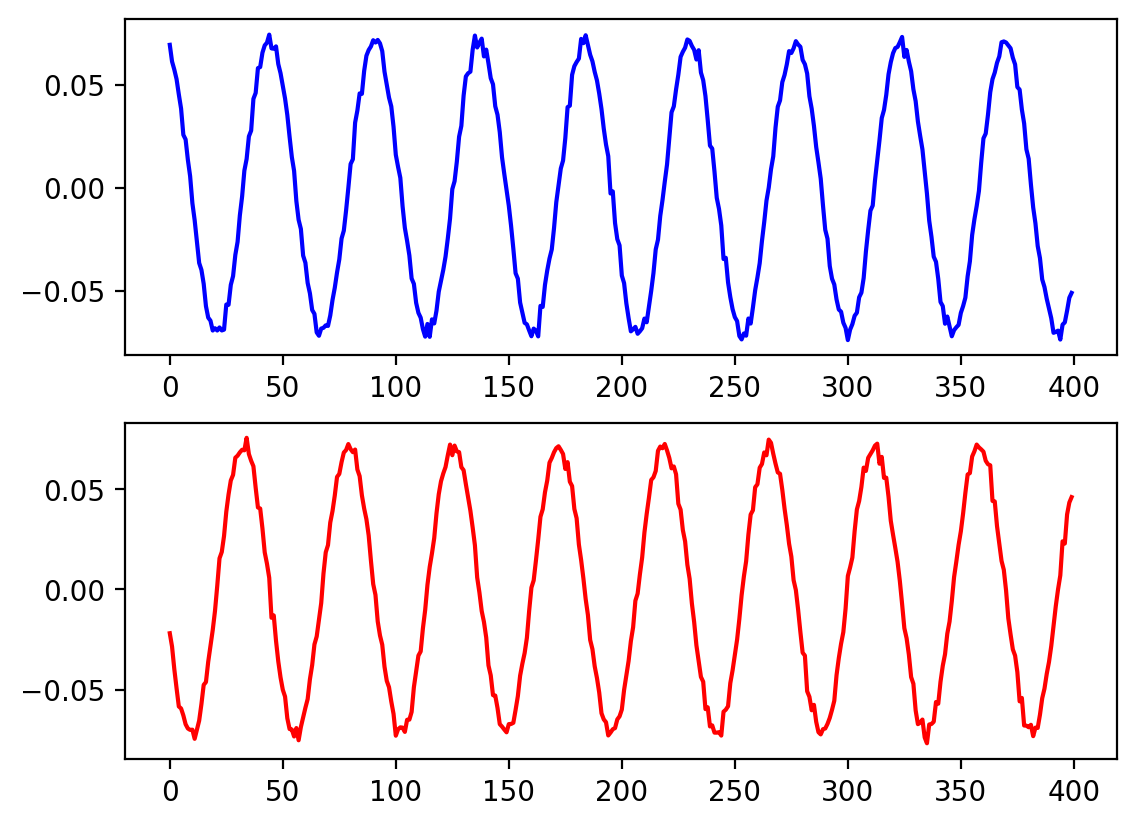

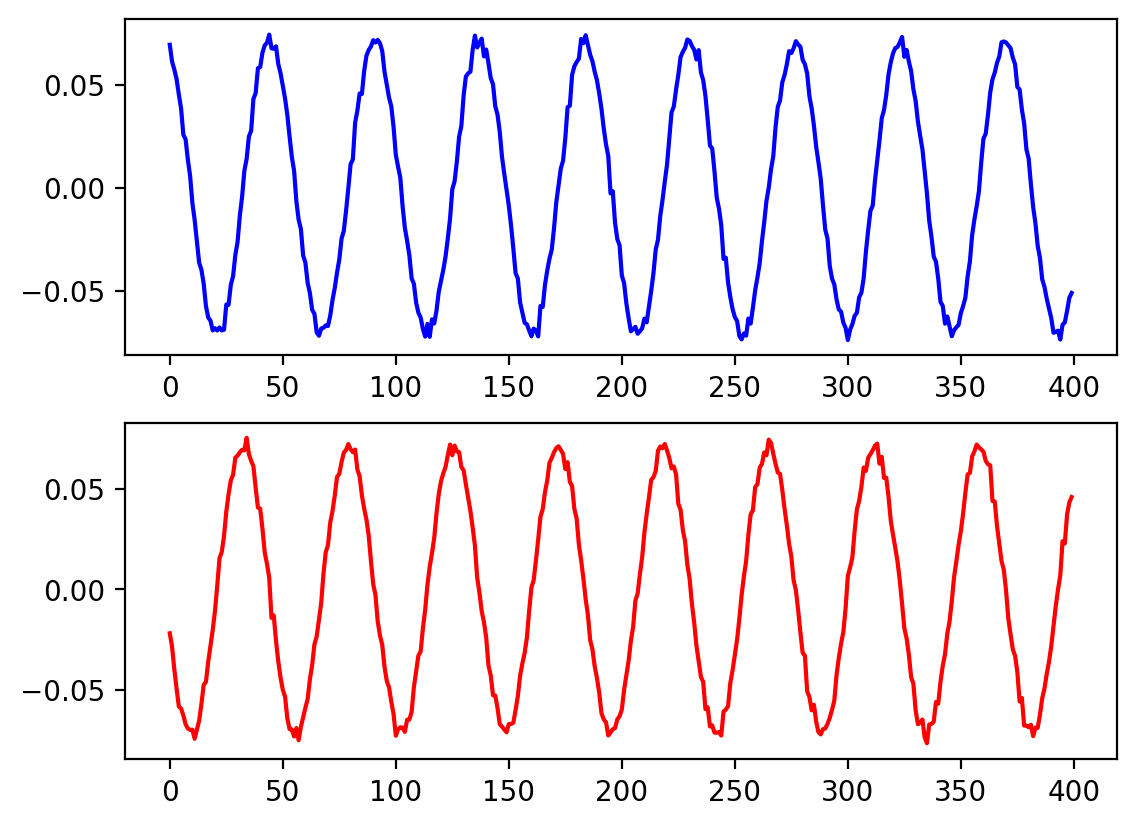

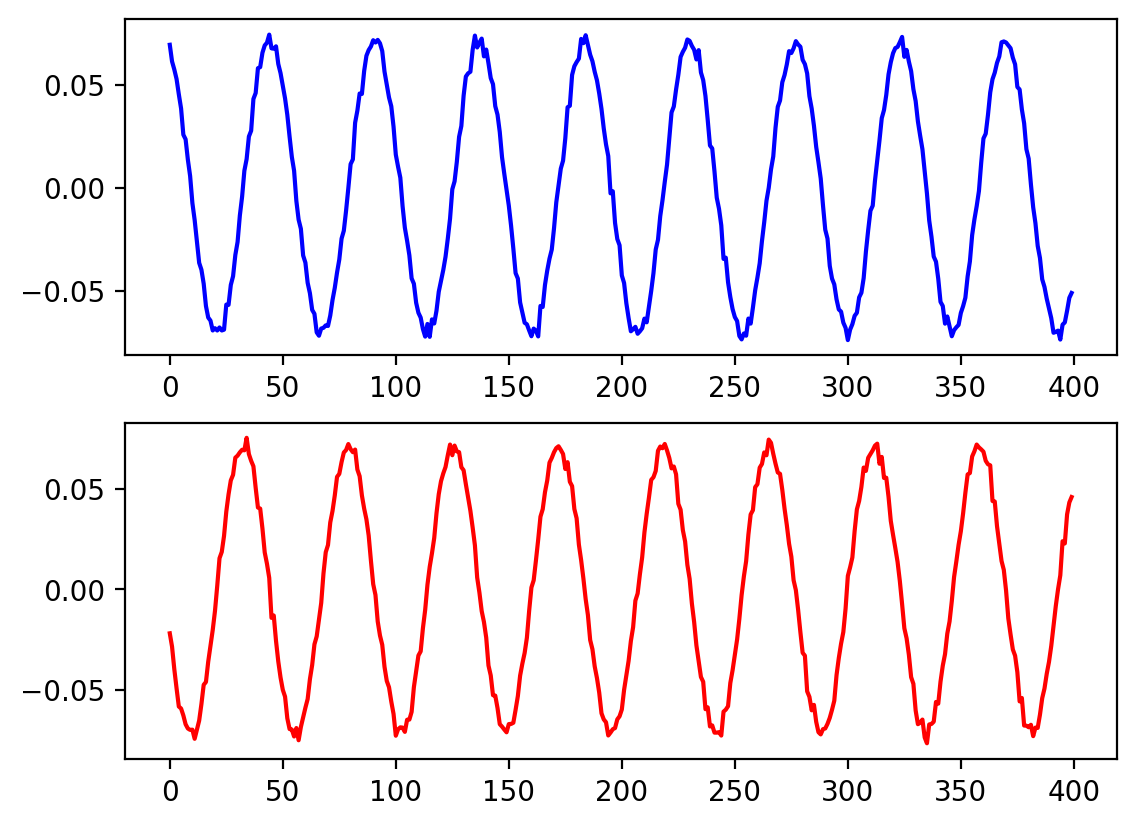

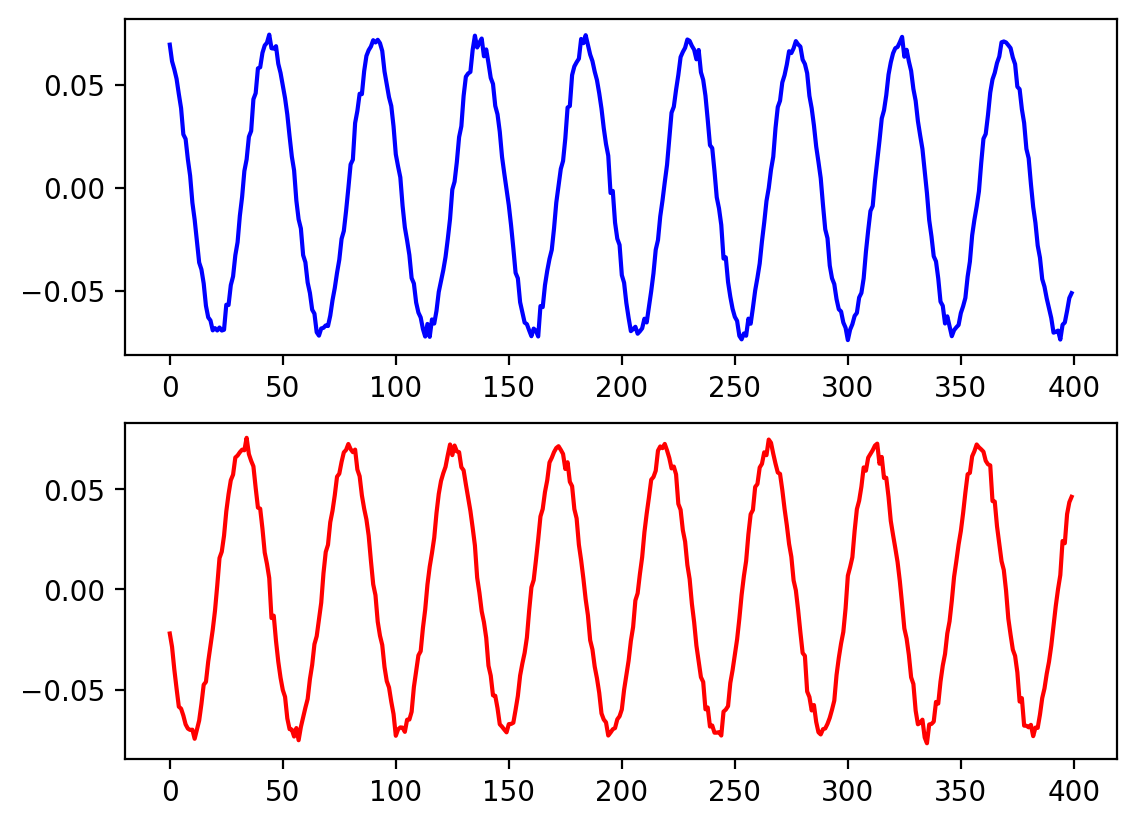

Done with training


In [5]:
col = ['b', 'r', 'g', 'c', 'm', 'y', 'k']

for iteration in range(n_iterations):
    # Forward pass
    hidden = torch.matmul(X_train, W)
    outputs = torch.matmul(hidden, W.T)
    reconstruction_loss = torch.mean((outputs - X_train) ** 2)

    # Backward pass
    optimizer.zero_grad()
    reconstruction_loss.backward()
    optimizer.step()

    # Visualization every 1000 iterations
    if iteration % 1000 == 0:
        with torch.no_grad():
            W_val = W.detach().numpy()
        plt.clf()
        for k in range(n_hidden):
            plt.subplot(n_hidden, 1, k + 1)
            plt.plot(W_val[:, k], col[k % len(col)])
        plt.show(block=False)
        plt.pause(0.001)

# Get codings
with torch.no_grad():
    codings_val = torch.matmul(X_test, W).numpy()

print("Done with training")


##### Question 1 (10 points)

What is an autoencoder? Please explain briefly. What would happen (ideally) if you pass a portion of signal x through the trained network?

###Answer Q.1:
An autoencoder is a specialized neural network composed of two main components: an encoder and a decoder. Its primary functions include dimensionality reduction and noise removal by compressing the input data into a lower-dimensional encoded representation and then reconstructing the original data from this compressed form.

In the realm of audio processing, when a segment of the signal $x$ is fed into a trained autoencoder, the encoder transforms the input signal into a compact latent space representation. Subsequently, the decoder takes this reduced representation and works to reconstruct the original signal as accurately as possible. Throughout training, the network adjusts its weights to minimize the difference between the original input and the reconstructed output, thereby ensuring that the reconstructed signal closely matches the original.

##### Question 2 (10 points)

Based on the observed shape of n_inputs and the definition of X_train, what exactly is being passed to the input layer of the network for a single forward pass? Be specific!

In [6]:
# Shape of x tarin
X_train.shape

torch.Size([148, 400])

In [7]:
# n_inputs
n_inputs

400

### Answer Q.2:
In a single forward pass, the network receives a batch of $148$ instances, each represented as a $400$-dimensional vector corresponding to an overlapping segment of the noisy sinusoidal signal. These instances are structured into a $148×400$ matrix. When fed into the network's input layer, the autoencoder encodes each window into a $2$-dimensional vector and decodes it back into a $400$-dimensional vector, reconstructing the original window.

##### Question 3 (10 points)

What variable(s) are used to represent the network weights? How are these weights initialized prior to training?

In [8]:
# Shape of W
W.shape

torch.Size([400, 2])

### Answer Q.3:
$W$, shaped as $(400×2)$, represents the network weights. In the encoding phase, $W$ is used directly, while in the decoding phase, its transpose $(2×400)$ is applied. These weights are initialized before training using a truncated normal distribution with a standard deviation of $0.1$.

A truncated normal distribution is a continuous probability distribution derived from the normal Gaussian distribution, but restricted to values within a specified range. Any values outside this range have zero probability.

Proper initialization of these weights is crucial, as it determines the optimization algorithm’s starting point. By choosing suitable initial values, training can proceed more efficiently, improve final performance, and enhance the model’s ability to generalize.

##### Question  4 (10 points)

What is being minimized in the reconstruction loss? Why is this helpful?

### Answer Q.4:
The reconstruction loss minimized during training is the mean squared error (MSE) between the original input data and the reconstructed output. This loss measures how closely the autoencoder’s output matches the original input. The squaring of the error terms ensures that larger errors are penalized more heavily than smaller ones, which makes the model focus on correcting significant deviations more effectively.
Minimizing the reconstruction loss allows the autoencoder to effectively recreate the input data. This helps the model focus on identifying the most important features of the data while ignoring noise and irrelevant details. This process is especially useful for tasks such as dimensionality reduction, noise removal, and creating compact data representations.

##### Question 5 (10 points)

What is an optimizer? What are 3 common optimizers? Which optimizer is used in this AE training?

### Answer Q.5:
An optimizer is an algorithm or method used to update the parameters of a model to minimize the loss function. It is an essential part of the training process, as it determines how the model improves its performance by adjusting the weights based on the data. There are different optimizers to choose from, and the choice can greatly impact how well the model performs.

Three common optimizers:

  - **Stochastic Gradient Descent (SGD)**: A simple and effective optimizer that updates parameters using the gradient of the loss function. It’s widely used but can be sensitive to the choice of learning rate, which can affect convergence.

  - **Adagrad**: This optimizer adapts the learning rate for each parameter based on the frequency of updates. Parameters that are updated frequently have their learning rates reduced, while less frequently updated parameters retain higher learning rates. This makes Adagrad effective for sparse data.

  - **Adam (Adaptive Moment Estimation)**: A widely used optimizer that combines the advantages of SGD and adaptive learning rates. Adam adjusts the learning rate for each parameter dynamically based on current and past gradients, making it efficient and well-suited for models with noisy data or non-linear relationships.

In this case, we are using the Adam optimizer, which is widely regarded as a reliable default for many machine learning tasks. Its versatility allows it to perform effectively across a variety of problem types with minimal configuration. Adam offers tunable hyperparameters, such as the learning rate and decay rates for gradient moving averages, enabling further optimization. It is particularly effective when dealing with noisy data or highly nonlinear relationships, often outperforming alternative optimizers in such scenarios.

We can examine now the "codings", i.e. the hidden unit values and their distribution. The more significant codings should have smaller variances.

mean:  [-0.01709789 -0.08811384]
variance [10.055578 10.034875]


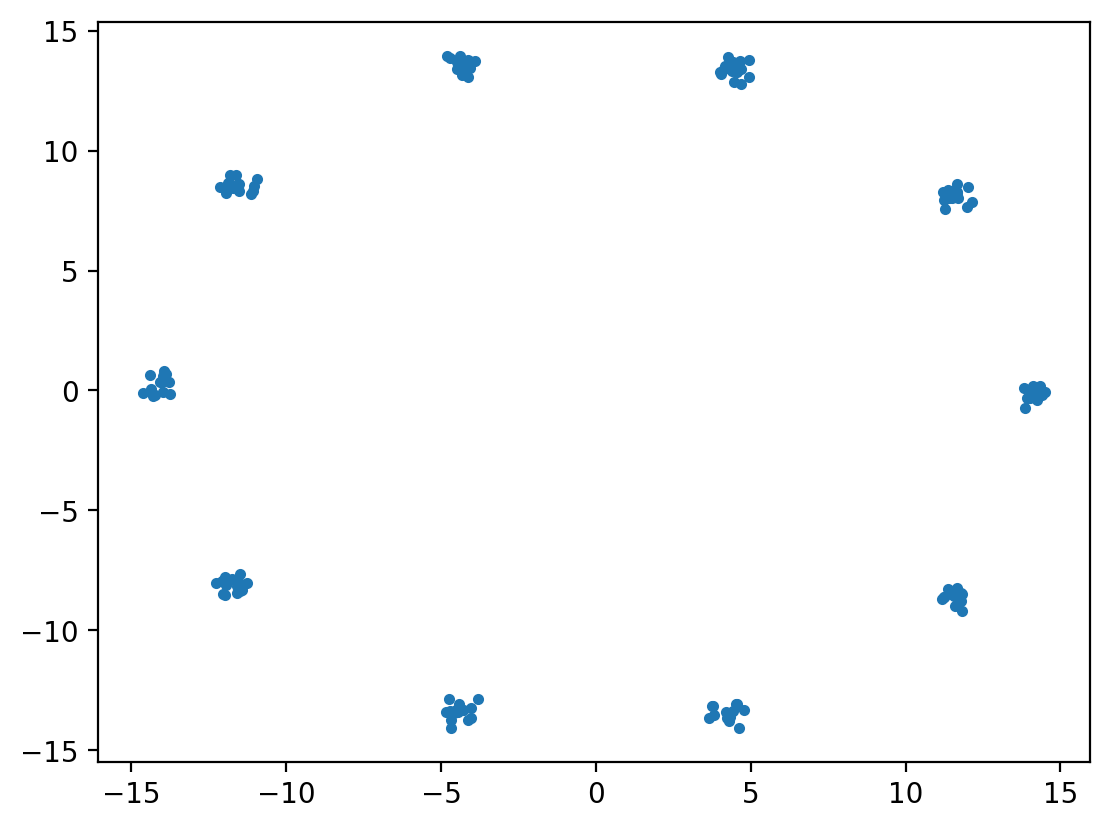

In [9]:
plt.plot(codings_val[:,0],codings_val[:,1],'.')
print ("mean: ", np.mean(codings_val,0))
print ("variance", np.std(codings_val,0))

###### Question 6 (10 points)

In what way does the autoencoder network function similarly to PCA?

### Answer Q.6:
Autoencoder networks and PCA are both common methods for reducing dimensionality and extracting key features from data. Both aim to simplify data representation by projecting it onto a lower-dimensional space while retaining the critical information.

However, there are significant differences between them:

 PCA is a linear algorithm that identifies orthogonal principal components by performing eigenvalue decomposition on the covariance matrix of the data, and it does not involve a training phase.

 On the other hand, autoencoders are neural networks designed to minimize reconstruction error through an unsupervised training process, enabling them to capture nonlinear relationships in the data. This ability allows autoencoders to uncover more intricate patterns compared to PCA, which is restricted to linear transformations.

 Additionally, PCA is purely algorithmic and straightforward, whereas autoencoders depend on the design and parameters of the neural network, making them more flexible but computationally demanding.

##### Question 7 - PCA versus AE (20 points)

Using sklearn.decomposition.PCA (or another PCA implementation in Python), illustrate the ideas you discuss in Question 1 & Question 7. You should have two plots: one showing the output of the AE network on a single sample, and another showing the output of your PCA on the same sample. How many principal components do you use in your reconstruction to achieve similar performance to the AE network?


### Answer Q.7:

Autoencoder Reconstruction MSE: 0.0863

Explained variance ratio for each component: [0.43044847]

PCA with 1 components - Reconstruction MSE: 0.5228


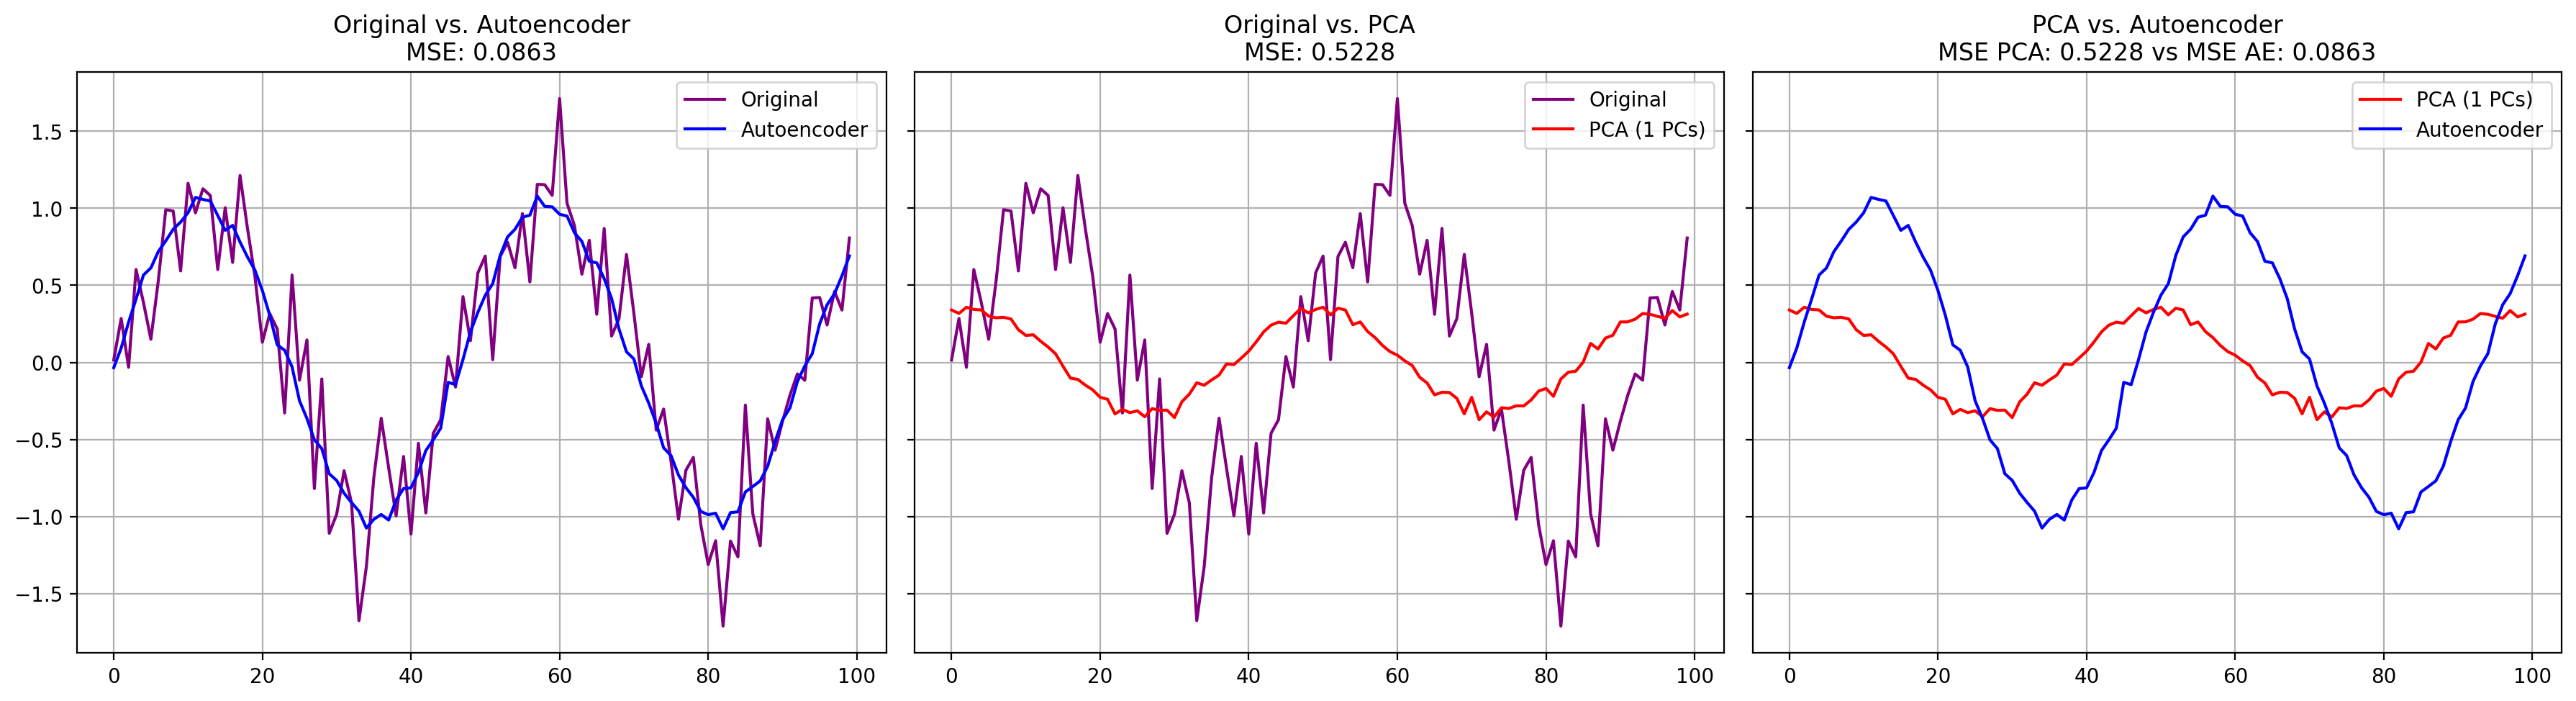


Explained variance ratio for each component: [0.43044847 0.42199412]

PCA with 2 components - Reconstruction MSE: 0.0852


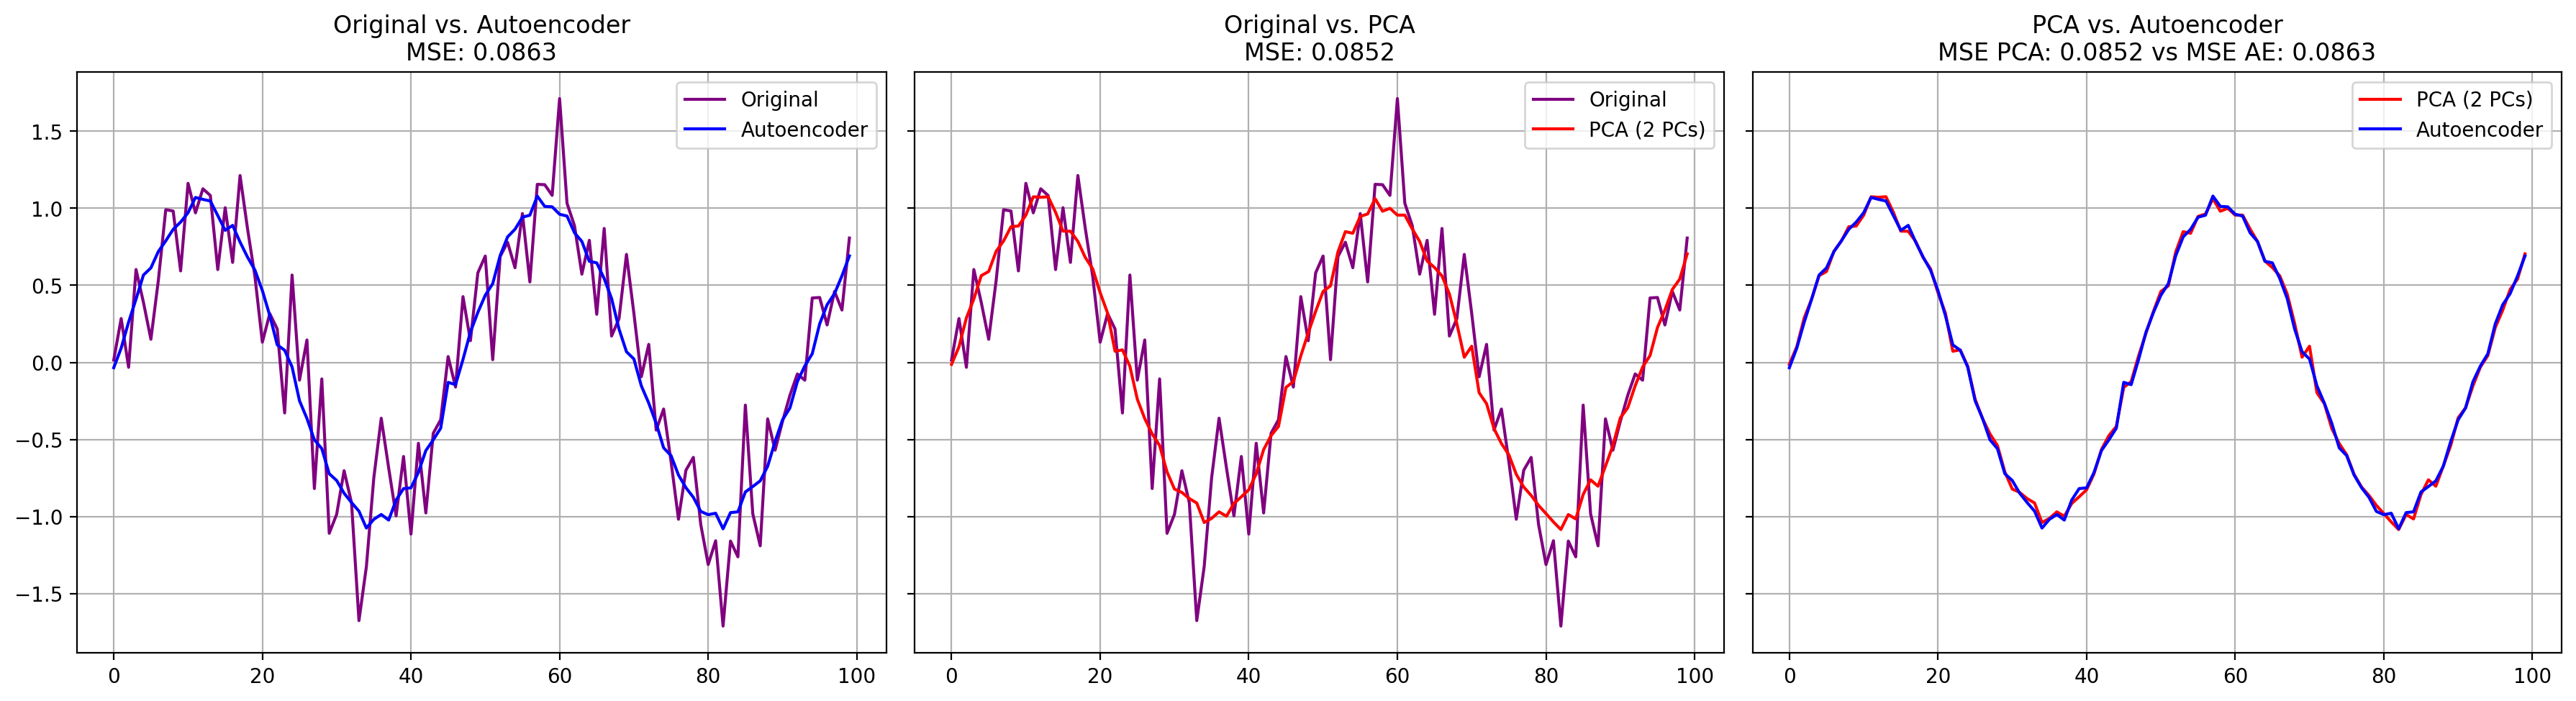


Explained variance ratio for each component: [0.43044847 0.42199412 0.00256085]

PCA with 3 components - Reconstruction MSE: 0.0851


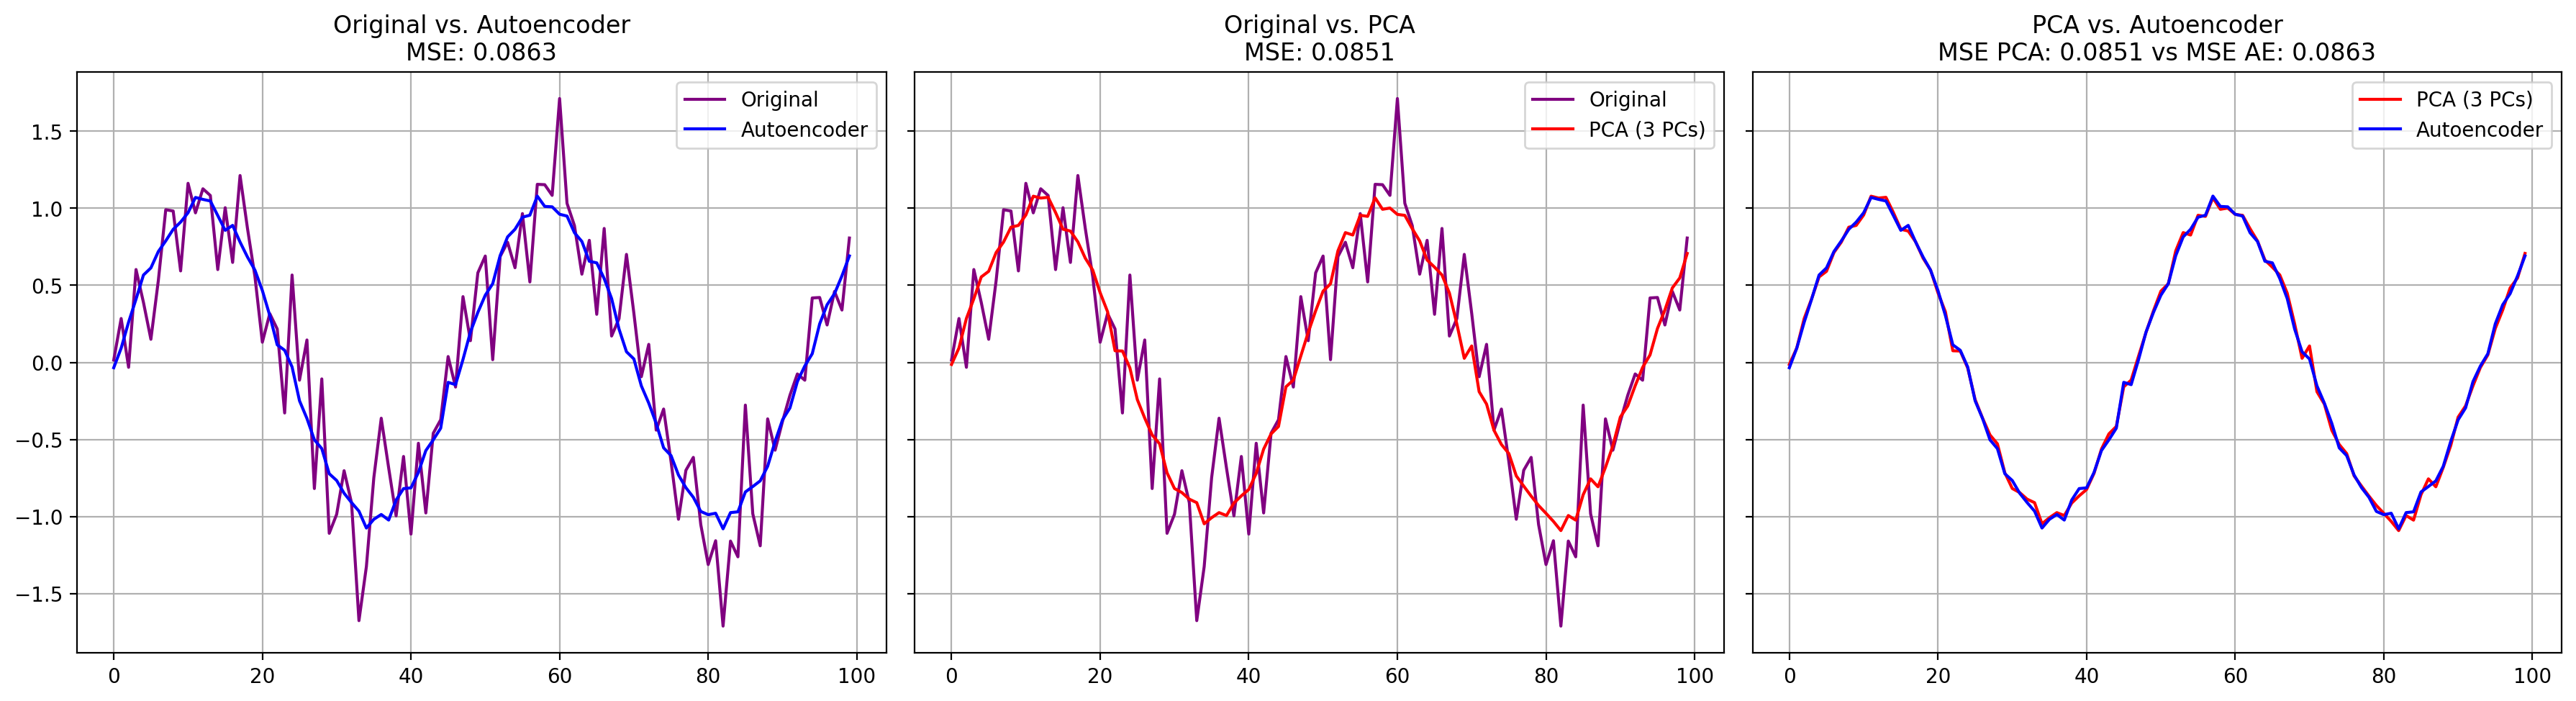


Explained variance ratio for each component: [0.43044847 0.42199412 0.00256085 0.00251683]

PCA with 4 components - Reconstruction MSE: 0.0837


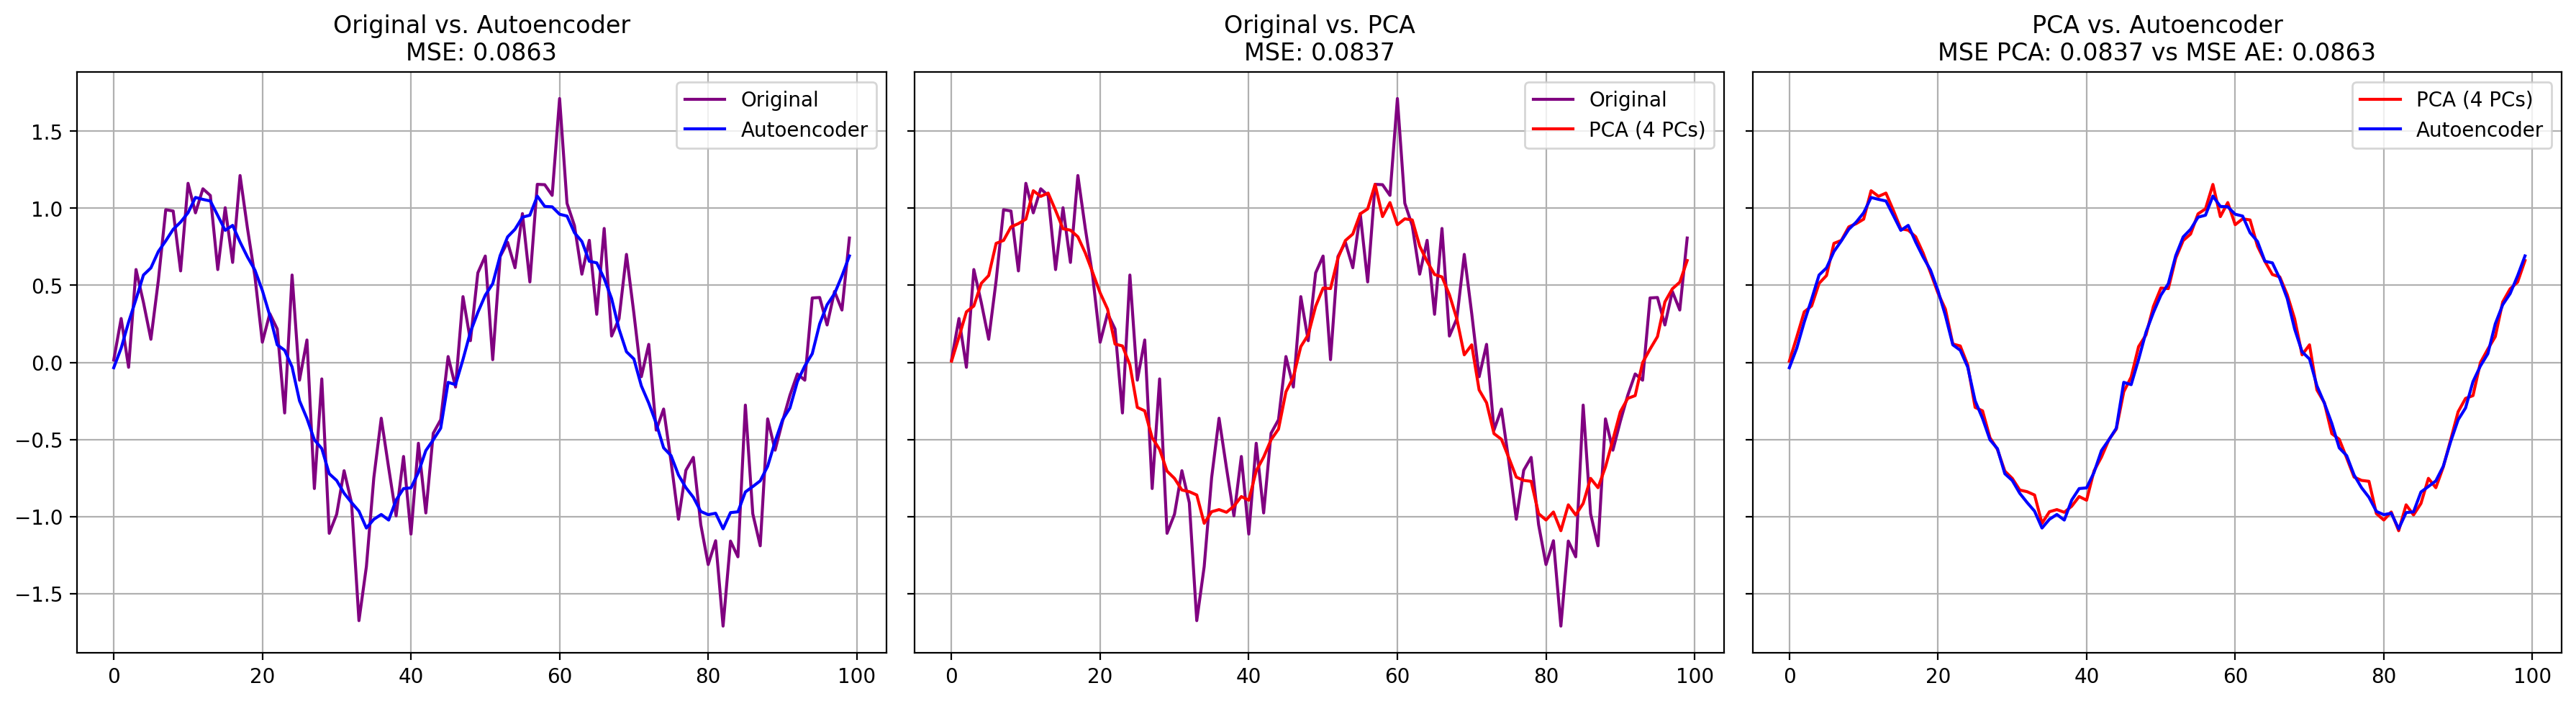


PCA achieves similar or better MSE to AE with 2 principal components.


In [10]:
from sklearn.decomposition import PCA

# Convert PyTorch tensors to NumPy arrays for PCA
X_train_np = X_train.detach().numpy()
X_test_np = X_test.detach().numpy()

def compute_ae_reconstruction(sample, W):
    with torch.no_grad():
        W_np = W.detach().numpy()
        encoded_sample = np.dot(sample, W_np)  # Encode (400D -> 2D)
        reconstruction = np.dot(encoded_sample, W_np.T)  # Decode (2D -> 400D)
    return reconstruction

def compute_pca_reconstruction(sample, pca):
    transformed = pca.transform(sample.reshape(1, -1))
    reconstruction = pca.inverse_transform(transformed)
    return reconstruction.flatten()

def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

def plot_reconstructions(num_pca_components):
    pca = PCA(n_components=num_pca_components)
    pca.fit(X_train_np)

    test_sample = X_test_np[0]
    ae_reconstruction = compute_ae_reconstruction(test_sample, W)
    pca_reconstruction = compute_pca_reconstruction(test_sample, pca)

    mse_ae = calculate_mse(test_sample, ae_reconstruction)
    mse_pca = calculate_mse(test_sample, pca_reconstruction)

    print(f'\nExplained variance ratio for each component: {pca.explained_variance_ratio_}')
    print(f'\nPCA with {num_pca_components} components - Reconstruction MSE: {mse_pca:.4f}')

    plot_range = slice(0, 100)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    axs[0].plot(test_sample[plot_range], color='purple', label="Original")
    axs[0].plot(ae_reconstruction[plot_range], color='blue', label="Autoencoder")
    axs[0].set_title(f"Original vs. Autoencoder\nMSE: {mse_ae:.4f}")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(test_sample[plot_range], color='purple', label="Original")
    axs[1].plot(pca_reconstruction[plot_range], color='red', label=f"PCA ({num_pca_components} PCs)")
    axs[1].set_title(f"Original vs. PCA\nMSE: {mse_pca:.4f}")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(pca_reconstruction[plot_range], color='red', label=f"PCA ({num_pca_components} PCs)")
    axs[2].plot(ae_reconstruction[plot_range], color='blue', label="Autoencoder")
    axs[2].set_title(f"PCA vs. Autoencoder\nMSE PCA: {mse_pca:.4f} vs MSE AE: {mse_ae:.4f}")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

    return mse_pca

# Compute AE MSE for reference
test_sample_full = X_test_np[0]
ae_reconstruction_full = compute_ae_reconstruction(test_sample_full, W)
mse_ae_full = calculate_mse(test_sample_full, ae_reconstruction_full)
print(f"Autoencoder Reconstruction MSE: {mse_ae_full:.4f}")

# Iterate over different number of PCA components to find similar MSE to AE
pca_components = range(1, 5)
mse_pca_list = []

for num in pca_components:
    mse_pca = plot_reconstructions(num)
    mse_pca_list.append(mse_pca)

# Determine the number of PCA components needed to achieve similar MSE to AE
for idx, mse_pca in enumerate(mse_pca_list, start=1):
    if mse_pca <= mse_ae_full:
        print(f"\nPCA achieves similar or better MSE to AE with {idx} principal components.")
        break
else:
    print("\nPCA does not achieve similar MSE to AE within 10 principal components.")


### **Explanation**:
To compare the performance of Principal Component Analysis (PCA) with the Autoencoder (AE), we evaluated two metrics: **explained variance ratio** and **Mean Squared Error** (MSE).

**The explained variance ratio** measures the proportion of variance captured by each principal component. The results show that the first two components together explain approximately 85% of the total variance, capturing the dataset's most significant structure. The third component, which explains only 0.25%, adds minimal information. Selecting the first two components strikes a balance between retaining critical information and reducing dimensionality.

**The Mean Squared Error** (MSE) quantifies reconstruction accuracy. PCA with 2 components achieves an MSE comparable to the AE’s performance when using a similar number of hidden units. This indicates that PCA is effective at capturing the essential features of the data, even with fewer components and less variance explained.

**Conclusion:**
Combining explained variance and MSE provides a comprehensive evaluation framework. PCA with 2 components achieves reconstruction accuracy similar to the AE, making it a competitive and efficient alternative.

##### Question 8 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

https://drive.google.com/file/d/1sE5C6TrMs-QtLYoE3goVunhuetBTSjlo/view?usp=sharing